# Deep Homography Net

In [2]:
import glob
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

config = tf.ConfigProto()
# config.gpu_options.allocator_type = 'BFC'
tf.Session(config = config)

C:\Users\TWright\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17176135646655554110
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3173089280
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14169972604584822105
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


## Data Wrangling

Read the directory

In [3]:
from os import path

train_split = 0.8
valid_split = 0.2

def load_img_paths(target):
    '''
    Retrieve the full path of all images in the dataset
    '''
    return glob.glob(target + '/*.tif')

data_dir = r'../data'
original_data_dir = path.join(data_dir, 'hnet_rotation_training_128_holdout_2019-05-24')
all_files = pd.read_csv(path.join(original_data_dir, 'homographies.tsv'), sep='\t')
all_files.head()

,Unnamed: 0,fname,h
0,0,Tp26_Y003_X006_040_0000,"80.0392,-64.5138,51.5139,16.0392,-29.0392,-12...."
1,1,Tp26_Y003_X006_040_0001,"18.4882,-7.5628,18.3128,-14.2618,25.0118,-14.4..."
2,2,Tp26_Y003_X006_040_0002,"38.2204,14.9990,30.5010,-28.7796,74.2796,-36.4..."
3,3,Tp26_Y003_X006_040_0003,"-19.6072,13.6267,-19.6267,11.3928,-17.3928,11...."
4,4,Tp26_Y003_X006_040_0004,"-6.1346,86.0332,-29.2832,12.6154,44.1346,-10.5..."


In [4]:
all_files = all_files.sample(frac=1, random_state=123) # shuffle with seed 123 for reproducability
train_paths = []
valid_paths = []

if train_split <= 1:
    frac = int(all_files.shape[0] * train_split)
    train_paths = all_files[:frac].values.tolist()
    valid_paths = all_files[frac:].values.tolist()
else:
    valid_frac = int(train_split * valid_split)
    train_paths = all_files[:train_split].values.tolist()
    valid_paths = all_files[train_split:train_split+valid_frac].values.tolist()

assert(len(train_paths) > 0)
print('Traning images:    %d' % len(train_paths))
print('Validation images: %d' % len(valid_paths))

Traning images:    45600
Validation images: 11400


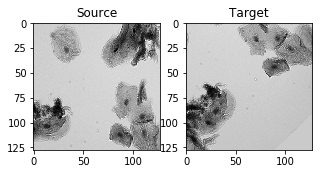

In [5]:
import matplotlib.pylab as plt
%matplotlib inline

def two_up(ref, mov):
    fig, (a, b) = plt.subplots(1, 2, figsize=(5, 8))
    a.imshow(ref, cmap='gray')
    a.set_title('Source')
    b.imshow(mov, cmap='gray')
    b.set_title('Target')
    plt.show()

def compare_all(ref, mov, pred):
    fig, (a, b, c) = plt.subplots(1, 3, figsize=(8, 8))
    a.imshow(ref, cmap='gray')
    a.set_title('Source')
    b.imshow(mov, cmap='gray')
    b.set_title('Target')
    c.imshow(pred, cmap='gray', vmin=0, vmax=255)
    c.set_title('Predicted')
    plt.show()
    
from imageio import imread
tm1 = imread(original_data_dir + '/Tp26_Y000_X000_040_0007_A.tif')
tm2 = imread(original_data_dir + '/Tp26_Y000_X000_040_0007_B.tif')
two_up(tm1, tm2)

## HomographyNet

Regression variant

> We use 8 convolutional layers with a max pooling layer (2x2, stride 2) after every two convolutions. The 8 convolutional layers have the following number of filters per layer: 64 [x4], 128 [x4]. The convolutional layers are followed by two fully connected layers. The first fully connected layer has 1024 units. Dropout with a probability of 0.5 is applied after the final convolutional layer and the first fully-connected layer.

> The regression network directly produces 8 real-valued
numbers and uses the Euclidean (L2) loss as the final layer
during training.

> using stochastic gradient descent (SGD) with momentum of 0.9. We use a base learning rate of 0.005 and decrease the learning rate by a factor of 10 after every 30,000 iterations.

In [8]:
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Dense, Flatten, MaxPooling2D, Input, Activation, Dropout
from keras.layers.convolutional import Conv2D
import keras.backend as K

def euclidean_distance(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1, keepdims=True))

def conv_block(m, filters):
    kernel = (3, 3)
    m = Conv2D(filters, kernel, padding='same', activation='relu')(m)
    return BatchNormalization()(m)

def conv_group(m, filters):
    m = conv_block(m, filters)
    m = conv_block(m, filters)
    return MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(m)

def homography_regression_model(input_dims):
    input_shape=(*input_dims, 2)
    
    input_layer = Input(shape=input_shape, name='input_layer')
    
    # 4x 64
    x = conv_group(input_layer, 64) # 1,2
    x = conv_group(x,           64) # 3,4
    # 4x 128
    x = conv_group(x,           128) # 1,2
    x = conv_block(x,           128) # 3
    x = conv_block(x,           128) # 4
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1024, name='FC_1024')(x)
    x = Dropout(0.5)(x)
    
    out = Dense(8, name='output')(x)
    
    return Model(inputs=input_layer, outputs=[out])

In [9]:
from keras.optimizers import SGD

img_size = tm1.shape[:2]

# opt = SGD(lr=0.005, momentum=0.9, decay=0.0015)
# opt = SGD(lr=0.005, momentum=0.9, decay=0.0)
opt = SGD(lr=0.001, momentum=0.9, decay=0.0)

my_model = homography_regression_model(img_size)
my_model.compile(optimizer=opt, loss=euclidean_distance)
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 128, 128, 2)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 64)      1216      
_________________________________________________________________
batch_normalization_9 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)        36928     
__________

## Data Generators

We generate the "seemingly infinite training data" on the fly by using Keras' DataGenerators.

In [10]:
import math
from os import path
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, LearningRateScheduler
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import Sequence
from skimage.transform import rotate


def h_string_to_arr(s):
    return np.array(list(map(lambda x: np.float32(x), s.split(','))))
    

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
class DataGenerator(Sequence):
    '''
    Adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html
    Allows for multiprocessing in the fit generator
    '''

    def __init__(self, train_set, batch_size, im_size, train_dir):
        self.train = train_set
        self.batch_size = batch_size
        self.im_size = im_size
        self.train_dir = train_dir

    def __len__(self):
        return int(np.ceil(len(self.train) / float(self.batch_size)))

    def invert(self, im):
        return abs(255 - im)
    
    def read_images(self, fname):
        ext = '.tif'
        base = path.join(self.train_dir, fname)
        a = self.invert(img_to_array(load_img(base + '_A' + ext, grayscale=True)))
        b = self.invert(img_to_array(load_img(base + '_B' + ext, grayscale=True)))
        return np.dstack((a,b))
    
    # Will output sequence of tuples (image, test) given a datapath
    def __getitem__(self, idx):
        X = np.zeros(shape=(batch_size, self.im_size[0], self.im_size[1], 2))
        y = np.zeros(shape=(batch_size, 8))
        batch = self.train[idx * self.batch_size:(idx + 1) * self.batch_size]
        for j,row in enumerate(batch):
            fname, h_str = row[1:]
            X[j] = self.read_images(fname)
            y[j] = h_string_to_arr(h_str)
        return (X, y)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

# create weights file if it doesn't exist for ModelCheckpoint
from os import mkdir
try: 
    mkdir('tmp')
except FileExistsError:
    print('tmp directory already exists')

history = LossHistory()

# def step_scheduler(epoch, lr):
#     step1 = int(epochs/3)
#     step2 = step1 * 2
#     if epoch == step1 or epoch == step2:
#         return lr * 0.1 # decrease by a factor of 10
#     return lr # no change

def step_scheduler(epoch, lr):
    step = int(epochs/3)
    if epoch % step == 0 and epoch > 0: # if this is a step epoch:
        new_lr = lr * 0.5 # decrease lr by some factor
        print('learning rate decreased from %f to %f' % (lr, new_lr))
        return new_lr   
    return lr # no change

lrScheduler = LearningRateScheduler(step_scheduler)

tmp directory already exists


## Training

> We use a base learning rate of 0.005 and decrease the learning rate by a factor of 10 after every 30,000 iterations.The networks are trained for for 90,000 total iterations using a batch size of 64.


In [11]:
from datetime import date

batch_size = 32
total_iterations = 60000

steps_per_epoch  = int(len(train_paths) / batch_size)
validation_steps = int(len(valid_paths) / batch_size)

epochs = int(total_iterations / steps_per_epoch)

training_generator   = DataGenerator(train_paths, batch_size, img_size, original_data_dir)
validation_generator = DataGenerator(valid_paths, batch_size, img_size, original_data_dir)

# descriptive weight file naming
out_name = 'hnet-weights-%d-%d_%s' % \
           (batch_size, img_size[0], date.today().isoformat())
checkpointer = ModelCheckpoint(filepath=('tmp/%s.hdf5' % out_name), 
                               verbose=1, save_best_only=True)

print('Epochs:            %d' % epochs)
print('Traning images:    %d' % len(train_paths))
print('Validation images: %d' % len(valid_paths))
print('Training steps:    %d' % steps_per_epoch)
print('Validation steps:  %d' % validation_steps)

Epochs:            42
Traning images:    45600
Validation images: 11400
Training steps:    1425
Validation steps:  356


In [12]:
hist = my_model.fit_generator(training_generator,
                              validation_data=validation_generator,
                              epochs=epochs,
                              workers=3,
                              verbose=2,
                              callbacks=[history, checkpointer, early_stopping, lrScheduler]
                             )

Epoch 1/42
 - 1627s - loss: 77.1974 - val_loss: 58.5026

Epoch 00001: val_loss improved from inf to 58.50259, saving model to tmp/hnet-weights-32-128_2019-05-24.hdf5
Epoch 2/42
 - 528s - loss: 50.5230 - val_loss: 58.6757

Epoch 00002: val_loss did not improve from 58.50259
Epoch 3/42
 - 524s - loss: 42.2809 - val_loss: 43.2750

Epoch 00003: val_loss improved from 58.50259 to 43.27497, saving model to tmp/hnet-weights-32-128_2019-05-24.hdf5
Epoch 4/42
 - 519s - loss: 37.7151 - val_loss: 40.0748

Epoch 00004: val_loss improved from 43.27497 to 40.07483, saving model to tmp/hnet-weights-32-128_2019-05-24.hdf5
Epoch 5/42
 - 518s - loss: 34.4548 - val_loss: 32.7276

Epoch 00005: val_loss improved from 40.07483 to 32.72758, saving model to tmp/hnet-weights-32-128_2019-05-24.hdf5
Epoch 6/42
 - 519s - loss: 32.3446 - val_loss: 42.4292

Epoch 00006: val_loss did not improve from 32.72758
Epoch 7/42
 - 531s - loss: 30.3833 - val_loss: 35.2879

Epoch 00007: val_loss did not improve from 32.72758


## Results inspection

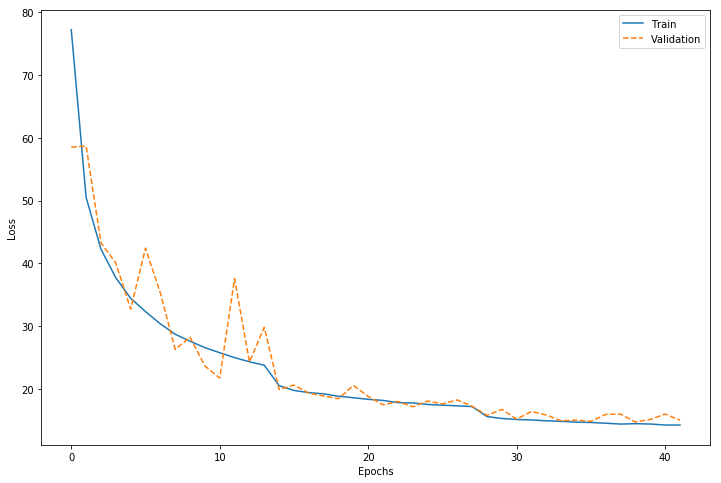

In [13]:
import json

with open('tmp/hnet-%s.json' % out_name, 'w') as fh:
    fh.write(json.dumps(hist.history))

plt.figure(figsize=(12,8))
plt.plot(hist.epoch,hist.history['loss'],    label='Train')
plt.plot(hist.epoch,hist.history['val_loss'],label='Validation',linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# load model if needed
my_model = homography_regression_model(img_size)
my_model.compile(optimizer=opt, loss=euclidean_distance)
my_model.load_weights('tmp/base_hnet-weights-32-112.hdf5')

[[ -0.5 -27.5]
 [-21.    8.5]
 [-23.   -3. ]
 [  2.   15. ]] 

 [[ 14.4922695  -8.212889 ]
 [  3.9114769  20.585794 ]
 [-24.887163   10.00512  ]
 [-14.306518  -18.793608 ]]


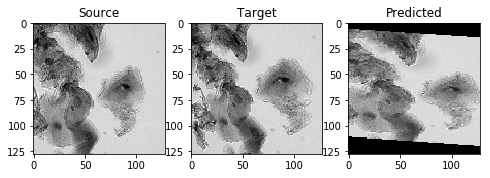

In [14]:
import cv2
from numpy.random import randint
from skimage.transform import resize

def alter_pt(pt, r):
    return (pt[0] + randint(-r,r), pt[1] + randint(-r,r))

def create_patch(im, size, r):
    '''
    Create pairs of patches from an image
    '''
    while True:
        # generate four random points
        x = randint(0, im.shape[1]-size)
        y = randint(0, im.shape[0]-size)
        tl = (x,y)
        tr = (tl[0], tl[1]+size)
        br = (tl[0]+size, tl[1]+size)
        bl = (tl[0]+size, tl[1])
        A = im[y:y+size,x:x+size] # this is our 'reference' image
        # alter points randomly by rho
        tl2 = alter_pt(tl, r)
        tr2 = alter_pt(tr, r)
        br2 = alter_pt(br, r)
        bl2 = alter_pt(bl, r)
        perturbed = np.float32([tl2, tr2, br2, bl2])
        # transform
        H = cv2.getPerspectiveTransform(np.float32([tl, tr, br, bl]), perturbed)
        Hab = np.linalg.inv(H) 
        # warp image
        full_warped = cv2.warpPerspective(im, Hab, im.shape, flags=cv2.INTER_NEAREST)
        B = full_warped[y:y+size,x:x+size]
        if A.shape == B.shape and A.mean() < 210:
            return A, B, np.subtract(perturbed, [tl, tr, br, bl])/2

def warp_pred(im, H):
    h,w = im.shape
    pts1 = np.array([[0, 0],
                     [0, h], 
                     [w, h], 
                     [w, 0]], dtype='float32')
    pts2 = H[0].reshape(4,2) + pts1
    return np.linalg.inv(cv2.findHomography(pts1, pts2)[0])
    
def invert(im):
    return abs(255 - im)
    
test_dir = r'../data/learning'
im1 = imread(test_dir + '/Tp26_Y001_X002_040.tif')
im1 = cv2.resize(im1, (672,512), interpolation=cv2.INTER_NEAREST)

p_a, p_b, H_act = create_patch(im1, 224, 56)
p_a = cv2.resize(p_a, img_size, interpolation=cv2.INTER_NEAREST)
p_b = cv2.resize(p_b, img_size, interpolation=cv2.INTER_NEAREST)

test_im = np.dstack((invert(p_a), invert(p_b)))
test_im = test_im.reshape(1, *test_im.shape)

H_4pt = my_model.predict(test_im)
H_pred = warp_pred(p_a, H_4pt)
predicted = cv2.warpPerspective(p_a, H_pred, img_size, flags=cv2.INTER_NEAREST)

print(H_act.reshape(4,2), '\n\n', H_4pt.reshape(4,2))
compare_all(p_a, p_b, predicted)

[[18.99367    4.471711 ]
 [11.184737  10.353742 ]
 [ 5.3027134  2.5448163]
 [13.111634  -3.3372135]]


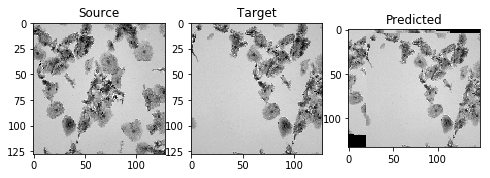

In [17]:
import sys
sys.path.insert(0, '../src')
from util import merge

test_dir = r'../data/learning'

im1 = cv2.imread(test_dir + '/Tp26_Y001_X005_040.tif', cv2.IMREAD_UNCHANGED)#[:, 256:]
im1 = cv2.resize(im1, img_size, interpolation=cv2.INTER_NEAREST)
# im1[:, 64:] = 0 # isolate the common area.

im2 = cv2.imread(test_dir + '/Tp26_Y001_X004_040.tif', cv2.IMREAD_UNCHANGED)#[:, :1024]
im2 = cv2.resize(im2, img_size, interpolation=cv2.INTER_NEAREST)
# im2[:, 0:64] = 0

test_im = np.dstack((invert(im1), invert(im2)))
test_im = test_im.reshape(1, *test_im.shape)
H_4pt = my_model.predict(test_im)
H_pred = warp_pred(im2, H_4pt)
warped = cv2.warpPerspective(im1, H_pred, img_size, flags=cv2.INTER_NEAREST)
predicted = merge(im2, warped, H_pred[0,2],H_pred[1,2])

print(H_4pt.reshape(4,2))
compare_all(im1, im2, predicted)

## Network performance on rigid transforms?

Here the network is performing estimates the homography between two images whose transformation is simply a vertical and horizontal shift. It was never seen these images.

[[16.011036 42.42478 ]
 [15.253434 38.55768 ]
 [19.120577 37.80017 ]
 [19.878063 41.667248]] 

 [-15.7933976  -43.84285547]


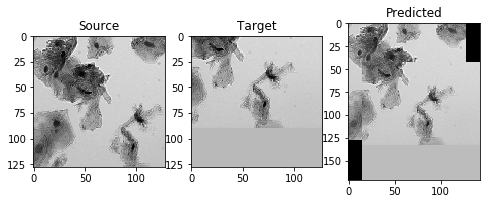

In [20]:
test_dir = r'../data/hnet_rigid_training_128_2019-05-13'

_id = '0290'
im1 = img_to_array(imread(test_dir + '/Tp26_Y000_X003_040_%s_A.tif' % _id))
im1 = cv2.resize(im1, img_size, interpolation=cv2.INTER_NEAREST)

im2 = img_to_array(imread(test_dir + '/Tp26_Y000_X003_040_%s_B.tif' % _id))
im2 = cv2.resize(im2, img_size, interpolation=cv2.INTER_NEAREST)

test_im = np.dstack((invert(im1), invert(im2)))
test_im = test_im.reshape(1, *test_im.shape)
H_4pt = my_model.predict(test_im)
H_pred = warp_pred(im1, H_4pt)
#predicted = cv2.warpPerspective(im1, H_pred, img_size, flags=cv2.INTER_NEAREST)
warped = cv2.warpPerspective(im1, H_pred, img_size, flags=cv2.INTER_NEAREST)
predicted = merge(im2, im1, *H_pred[:2,2])

print(H_4pt.reshape(4,2), '\n\n', H_pred[:2,2])
compare_all(im1, im2, predicted)